In [58]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import nibabel as nib
import SimpleITK as sitk
from typing import List
from utils.general_utils import plot_imgs, plot_sitk_img, save_sitk_from_nda
from utils.utils import save_nifti_from_array, crop_img, obtain_brain_mask
import cc3d
import json
from scipy.ndimage.morphology import binary_dilation, generate_binary_structure
from shutil import move
this_path = Path().resolve()

In [59]:
# obtain intensity distribution of all images per group
def get_intensity_distribution(md_df, root_dir: Path, map_types: List, bin=None, windowed: bool = False):
    
    md_df.reset_index(inplace=True, drop=True)
    subjects_list = []
    masks_paths = []
    sub_ids = []
    # get all subjects paths in group
    for i in range(len(md_df)):
        subid = md_df['id'][i]
        subj_dir = root_dir / subid / 'Results'
        if windowed:
            hmri_files = sorted(list(subj_dir.glob('*_w.nii')), key=lambda x: x.stem)
        else:
            hmri_files = sorted(list(subj_dir.glob('*.nii')), key=lambda x: x.stem)

        hmri_files = [x for x in hmri_files if any(sub in x.stem for sub in map_types)]

        masks_paths.append(subj_dir / f'Masks/{subid}_brain_mask_mtsat_w.nii')
        subjects_list.append(hmri_files)
        sub_ids.append(subid)
    
    intensities = []
    stats = []
    for i in range(len(masks_paths)):
        img_stats = {}
        mask = sitk.GetArrayFromImage(sitk.ReadImage(str(masks_paths[i]))).astype(bool)
        mask = mask.astype(bool)
        img = sitk.GetArrayFromImage(sitk.ReadImage(str(subjects_list[i][0])))
        img_masked = img[mask]
        img_stats['mean'] = np.mean(img_masked)
        img_stats['std'] = np.std(img_masked)
        img_stats['min'] = np.min(img_masked)
        img_stats['max'] = np.max(img_masked)
        stats.append(img_stats)
        intensities.extend(img_masked.flatten())    
    
    stats = pd.DataFrame(stats)
    stats['id'] = sub_ids

    if bin is not None:
        minval = np.min(intensities)
        maxval = np.max(intensities)    
        hist,_ = np.histogram(intensities, bins=bin, range=(minval, maxval))
        return hist
    else:
        return intensities, stats

In [91]:
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
md_df_hc = md_df[md_df['group'] == 0]
md_df_hc_f = md_df_hc[md_df_hc['sex'] == 1]
md_df_hc_m = md_df_hc[md_df_hc['sex'] == 0]

md_df_pd = md_df[md_df['group'] == 1]
md_df_pd.drop(md_df_pd[md_df_pd['id'] == 'sub-058'].index, inplace=True)
md_df_pd_f = md_df_pd[md_df_pd['sex'] == 1]
md_df_pd_m = md_df_pd[md_df_pd['sex'] == 0]

/tmp/ipykernel_3703777/3669284539.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md_df_pd.drop(md_df_pd[md_df_pd['id'] == 'sub-058'].index, inplace=True)


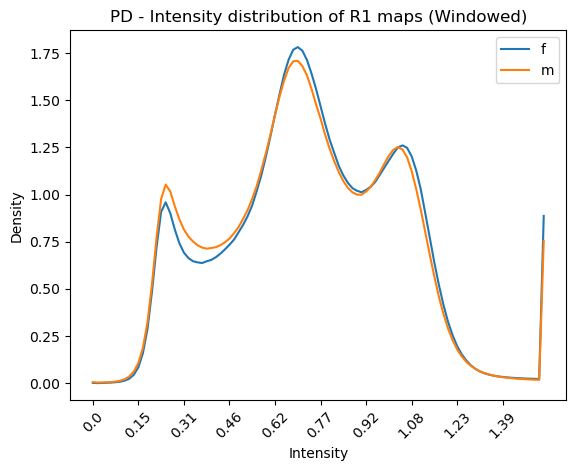

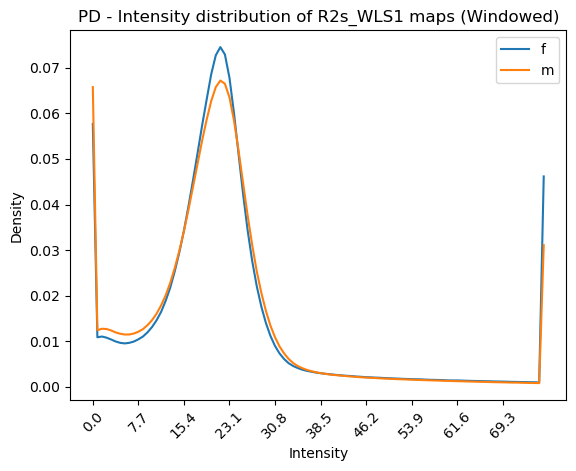

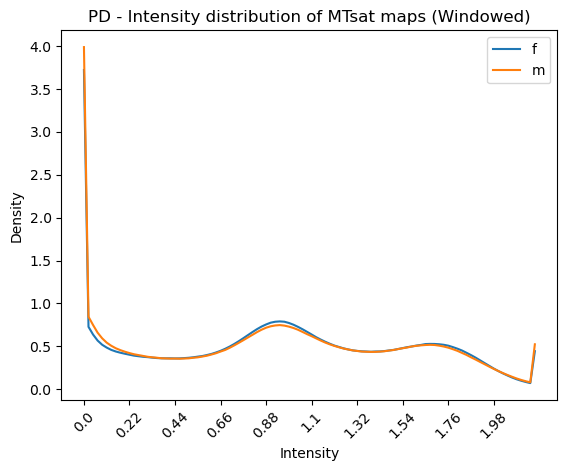

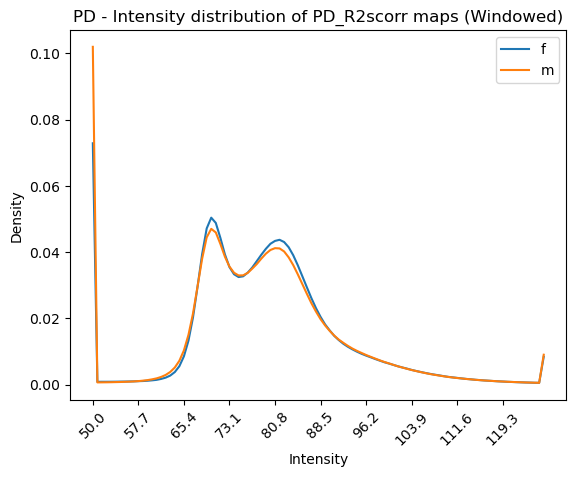

In [93]:
# map_type = 'R1'

group = 'PD'
for map_type in ['R1', 'R2s_WLS1', 'MTsat', 'PD_R2scorr']:

    intens_hc_f, _ = get_intensity_distribution(md_df_pd_f, root_dir, [map_type], windowed=True)
    intens_hc_m, _ = get_intensity_distribution(md_df_pd_m, root_dir, [map_type], windowed=True)

    hist_hc, edges = np.histogram(intens_hc_f, bins=100, range=(np.min(intens_hc_f), np.max(intens_hc_f)), density=True)
    plt.plot(hist_hc, label='f')
    hist_pd, edges = np.histogram(intens_hc_m, bins=100, range=(np.min(intens_hc_m), np.max(intens_hc_m)), density=True)
    plt.plot(hist_pd, label='m')
    plt.legend()
    plt.xlabel('Intensity')
    plt.ylabel('Density')
    plt.title(f'{group} - Intensity distribution of {map_type} maps (Windowed)')
    # correct ticks with edges
    plt.xticks(np.arange(0, 100, 10), edges[::11].round(2), rotation=45)
    plt.show()

In [74]:
stats_hc

,mean,std,min,max,id
0,76.625954,11.294082,50.0,120.0,sub-012
1,77.141045,10.697887,50.0,120.0,sub-020
2,75.577759,11.360682,50.0,120.0,sub-022
3,77.356705,11.180560,50.0,120.0,sub-026
4,76.783798,12.376409,50.0,120.0,sub-027
5,76.961281,12.613480,50.0,120.0,sub-028
6,77.744110,11.426899,50.0,120.0,sub-030
7,77.460732,11.043262,50.0,120.0,sub-032
8,77.103790,11.111012,50.0,120.0,sub-033
9,77.558739,12.456571,50.0,120.0,sub-034


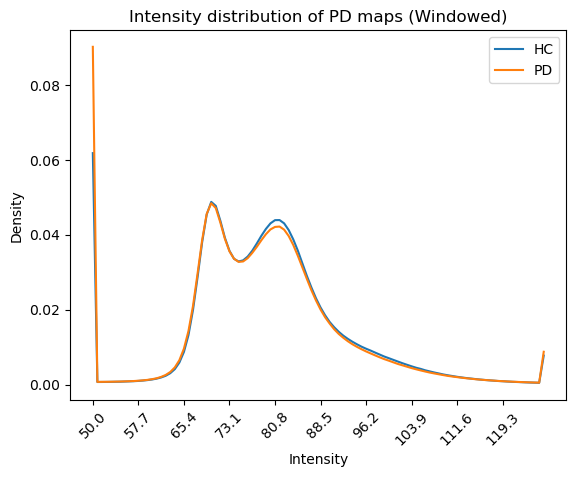

In [75]:
hist_hc, edges = np.histogram(intens_hc, bins=100, range=(np.min(intens_hc), np.max(intens_hc)), density=True)
plt.plot(hist_hc, label='HC')
hist_pd, edges = np.histogram(intens_pd, bins=100, range=(np.min(intens_pd), np.max(intens_pd)), density=True)
plt.plot(hist_pd, label='PD')
plt.legend()
plt.xlabel('Intensity')
plt.ylabel('Density')
plt.title('Intensity distribution of PD maps (Windowed)')
# correct ticks with edges
plt.xticks(np.arange(0, 100, 10), edges[::11].round(2), rotation=45)
plt.show()

In [28]:
stats

,mean,std,min,max,id
0,0.810302,0.588357,-5.0,5.0,sub-012
1,0.790550,0.557968,-5.0,5.0,sub-020
2,0.873329,0.613601,-5.0,5.0,sub-022
3,0.869487,0.595728,-5.0,5.0,sub-026
4,0.844969,0.628735,-5.0,5.0,sub-027
5,0.816353,0.614159,-5.0,5.0,sub-028
6,0.714998,0.555086,-5.0,5.0,sub-030
7,0.808079,0.586119,-5.0,5.0,sub-032
8,0.874742,0.619800,-5.0,5.0,sub-033
9,0.861947,0.672326,-5.0,5.0,sub-034


(array([1.097400e+04, 3.520000e+02, 4.310000e+02, 4.240000e+02,
        4.510000e+02, 4.710000e+02, 5.820000e+02, 5.710000e+02,
        6.200000e+02, 6.300000e+02, 7.030000e+02, 7.350000e+02,
        7.710000e+02, 8.900000e+02, 9.060000e+02, 1.045000e+03,
        1.157000e+03, 1.117000e+03, 1.292000e+03, 1.418000e+03,
        1.499000e+03, 1.719000e+03, 1.835000e+03, 2.056000e+03,
        2.258000e+03, 2.563000e+03, 2.713000e+03, 3.050000e+03,
        3.364000e+03, 3.846000e+03, 4.425000e+03, 4.826000e+03,
        5.497000e+03, 6.239000e+03, 7.245000e+03, 8.394000e+03,
        9.679000e+03, 1.115400e+04, 1.268000e+04, 1.531800e+04,
        1.778400e+04, 2.150800e+04, 2.510100e+04, 3.118000e+04,
        3.859900e+04, 4.928900e+04, 6.681100e+04, 1.029180e+05,
        2.338170e+05, 1.383182e+06, 2.759122e+06, 1.792623e+06,
        1.496418e+06, 1.368522e+06, 1.352342e+06, 1.479430e+06,
        1.821172e+06, 2.366199e+06, 2.747194e+06, 2.575742e+06,
        2.103083e+06, 1.743684e+06, 1.60

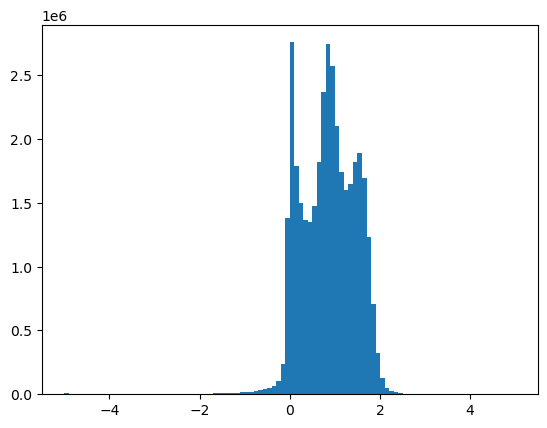

In [31]:
plt.hist(intensities_array, bins=100, range=(np.min(intensities_array), np.max(intensities_array)))

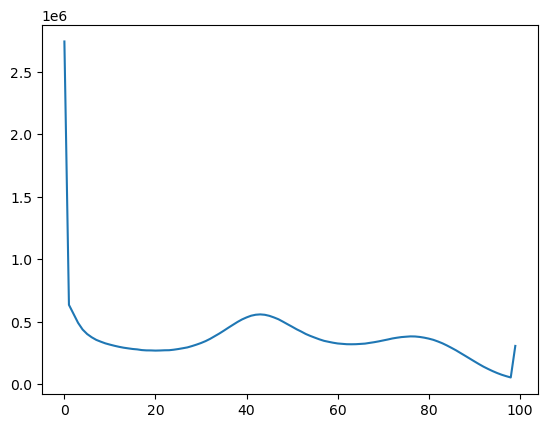

In [23]:
hist,_ = np.histogram(intensities_array, bins=100)
plt.plot(hist)

(array([6657834., 2864940., 2831772., 4187371., 5322936., 3846767.,
        3253720., 3706476., 2929688., 1290006.]),
 array([0.        , 0.2       , 0.40000001, 0.60000002, 0.80000001,
        1.        , 1.20000005, 1.39999998, 1.60000002, 1.79999995,
        2.        ]),
 <BarContainer object of 10 artists>)

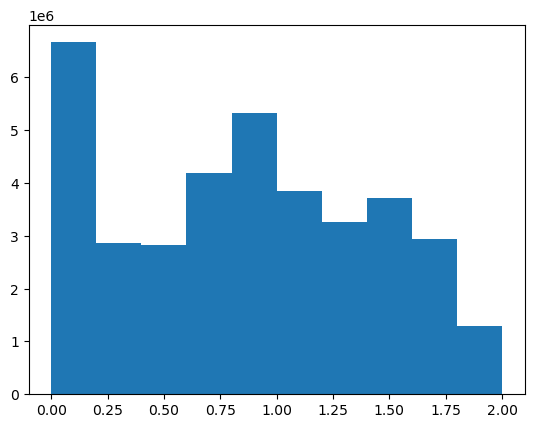

In [25]:
plt.hist(intensities_array)

In [24]:
stats

,mean,std,min,max,id
0,0.825620,0.534772,0.0,2.0,sub-012
1,0.797121,0.540163,0.0,2.0,sub-020
2,0.889072,0.551170,0.0,2.0,sub-022
3,0.878669,0.564404,0.0,2.0,sub-026
4,0.865963,0.552067,0.0,2.0,sub-027
5,0.837657,0.539818,0.0,2.0,sub-028
6,0.728325,0.519777,0.0,2.0,sub-030
7,0.818316,0.554681,0.0,2.0,sub-032
8,0.886847,0.580763,0.0,2.0,sub-033
9,0.882596,0.592933,0.0,2.0,sub-034


In [10]:
print(subjects_list_hc[0])
print(masks_paths_hc[0])

[PosixPath('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/sub-012/Results/sub-012_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_MTsat_w.nii')]
/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/sub-012/Results/Masks/sub-012_brain_mask_mtsat_w.nii
